In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

Здесь задается система оду, на временном ряде и нее тренировалась модель

In [2]:
def dk(self, X):
    x1, y1, z1, x2, y2, z2 = X
    return [y1 + b*x1**2 - a*x1**3 -z1 + I - k1*(x1-vs)*G(x2),
            c - d*x1**2 - y1,
            r*(s*(x1 - xr) - z1),
            y2 + b*x2**2 - a*x2**3 -z2 + I - k2*(x2-vs)*G(x1),
            c - d*x2**2 - y2,
            r*(s*(x2 - xr) - z2)        
    ]
 
def G(x):
    return 1/(1+np.exp(-lam*(x-teta)))

Параметры системы оду

In [3]:
a = 1
b = 3
c = 1
d = 5
xr = -1.6
r = 0.01
s = 5
I = 4
vs = 2
lam = 10
teta = -0.25
k1 = 0.25
k2 = 0.25

Решатель оду (интегратор)

In [16]:
sol = solve_ivp(dk, [0, 25020], [-0.1, 0.1, -0.1, -0.1, -0.1, -0.1], 
                t_eval=np.array(range(20, 25020, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

Наблюдаемый временной ряд это x1 + x2

In [17]:
data = sol.y[0] + sol.y[3]
mean = data.mean()
std = data.std()
mean + 6*std

4.783275131189474

Посмотрели на распределение данных

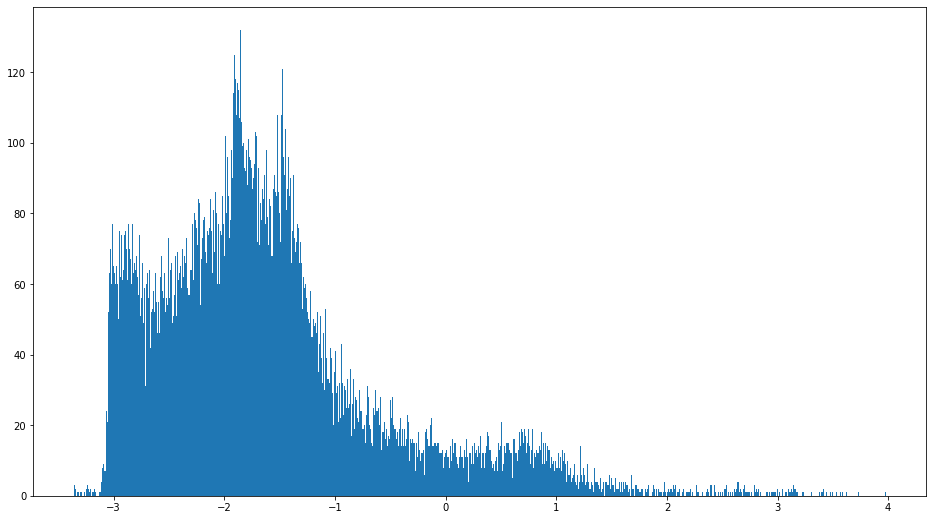

In [11]:
plt.figure(figsize=(16, 9))
plt.hist(data, bins=1000)
plt.show()

Тем же решателем оду посчитали данные и теперь просто подгружаем их, бьем на тест и трейн и нормируем

In [2]:
data = np.load("DKChaosSmall.npy")
#data = data[0] + data[3]

train = data[:10000]
test =  data[10000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [3]:
test.shape

(2500,)

Лстм мы будем учить по 20 предыдущим отсчетам, поэтому формируем датасет, где x это 20 отсчетов, а target это 21-й отсчет

In [4]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [5]:
from torch.utils.data import DataLoader

Загружаем в даталоадеры, чтобы обучать батчами

In [6]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

Лстм модель: linear -> lstm -> dropout -> linear

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

Инициализируем

In [8]:
model = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cuda')

Функция прогона одной эпохи

In [9]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

In [10]:
from IPython.display import clear_output

тренировка

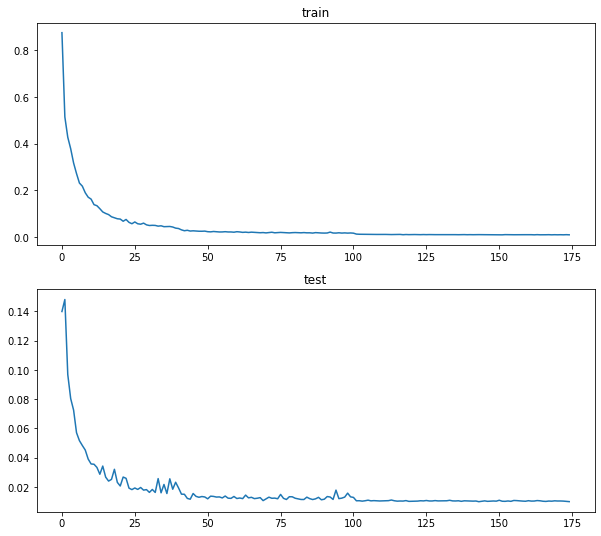

Epoch[175/175] | loss train:0.009127, test:0.010001


In [11]:
# define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
lr = 0.001

losses_train = []
losses_test = []
# begin training
for epoch in range(175): 
    if epoch > 40:
        lr = 0.0005
    if epoch > 100:
        lr = 0.0001
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9)    
    loss_train = run_epoch(model, train_dataloader, is_training=True)
    loss_val = run_epoch(model, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 175, loss_train, loss_val))

In [76]:
#torch.save(model.state_dict(), "./DKChaosLSTM")

In [77]:
#np.save("DKChaosSmall", data)

Функция подсчета метрики рмсе для предсказания на различное число шагов от 1 до 20

In [12]:
def GetRmse(model, train_dataloader, val_dataloader, test, std, mean):
    model.eval()

    rmse = []

    for k in range(1, 20):
        test_right_part = (len(test)- 20)%64
        predicted_val = np.array([])
        for idx, (x, y) in enumerate(val_dataloader):
            x = torch.reshape(x, (64, 20, 1)).to('cuda')
            cur_x = x
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
            predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse

In [13]:
rmse_chaos = GetRmse(model, train_dataloader, test_dataloader, test, std, mean)

In [14]:
model2 = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model2 = model2.to('cuda')
model2.load_state_dict(torch.load("./DKDeepLSTM"))

<All keys matched successfully>

In [15]:
data1 = np.load("DK_time_series_for_new_loss.npy")
data1 = data1[0] + data1[3]

train1 = data1[:10000]
test1 =  data1[10000:]

mean1 = train1.mean()
std1 = train1.std()
#sigmastest = np.abs(test - mean)
train_norm1 = (train1 - mean1)/std1
test_norm1 = (test1 - mean1)/std1

train_norm1 = torch.FloatTensor(train_norm1).view(-1)
test_norm1 = torch.FloatTensor(test_norm1).view(-1)

In [16]:
train_inout_seq1 = create_inout_sequences(train_norm1, train_window)
test_inout_seq1 = create_inout_sequences(test_norm1, train_window)

train_dataloader1 = DataLoader(train_inout_seq1, batch_size=64, shuffle=True, drop_last=True)
test_dataloader1 = DataLoader(test_inout_seq1, batch_size=64, shuffle=False, drop_last=True)

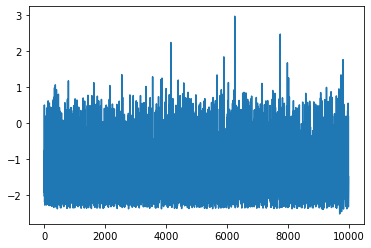

In [52]:
plt.plot(train1)

In [17]:
rmse_hyp_chaos = GetRmse(model2, train_dataloader1, test_dataloader1, test1, std1, mean1)

In [18]:
import matplotlib.ticker as ticker

Text(0.5, 0, 'prediction step')

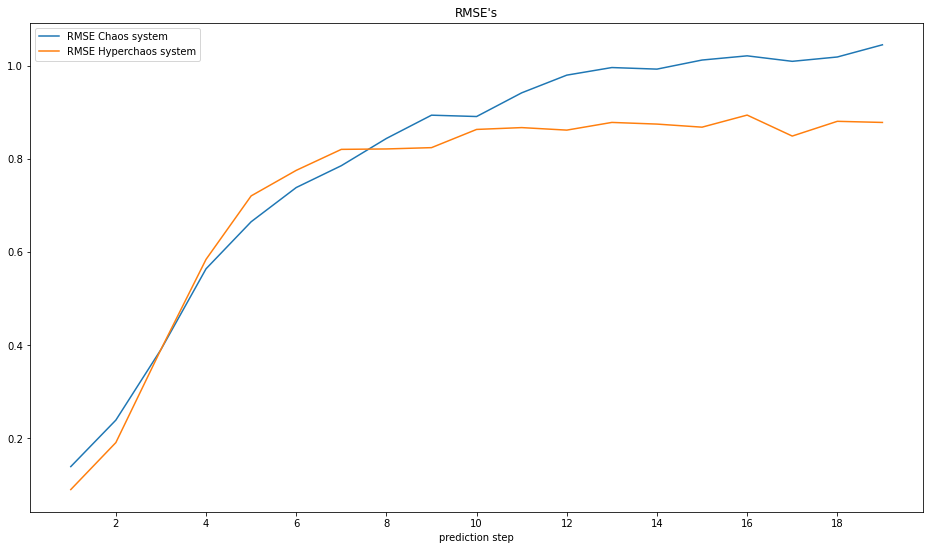

In [19]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), rmse_chaos, label="RMSE Chaos system")
ax.plot(list(range(1, 20)), rmse_hyp_chaos, label="RMSE Hyperchaos system")
ax.legend()
ax.set_title("RMSE's")
ax.set_xlabel("prediction step")

Text(0.5, 0, 'prediction step')

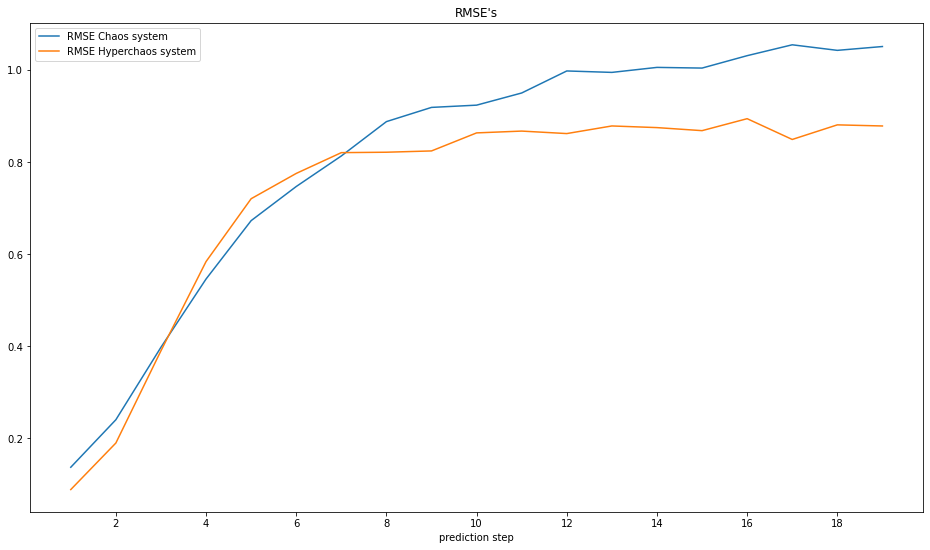

In [63]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), rmse_chaos, label="RMSE Chaos system")
ax.plot(list(range(1, 20)), rmse_hyp_chaos, label="RMSE Hyperchaos system")
ax.legend()
ax.set_title("RMSE's")
ax.set_xlabel("prediction step")

Функция предсказания, которая отрисовывает предсказаный график и настоящий на число шагов k

In [67]:
def ShowPredict(model1, k, train_dataloader, val_dataloader, test_norm):
    test_right_part = (len(test)- 20)%64
    predicted_val = np.array([])
    for idx, (x, y) in enumerate(val_dataloader):
        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        cur_x = x
        for _ in range(k):
            out = model1(cur_x.to('cuda'))
            cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
        predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
        
        
    fig = plt.figure(figsize=(16, 12))
        
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_1.plot(test_norm[20+k-1:], label='true')
    if k == 1:
        ax_1.plot(predicted_val[:],  linestyle = '--', label='predicted')
    else:
        ax_1.plot(predicted_val[:-k+1],  linestyle = '--', label='predicted')
    ax_1.set_title("RMSE k = {0}".format(k))
    ax_1.legend()
    
    
    plt.show()

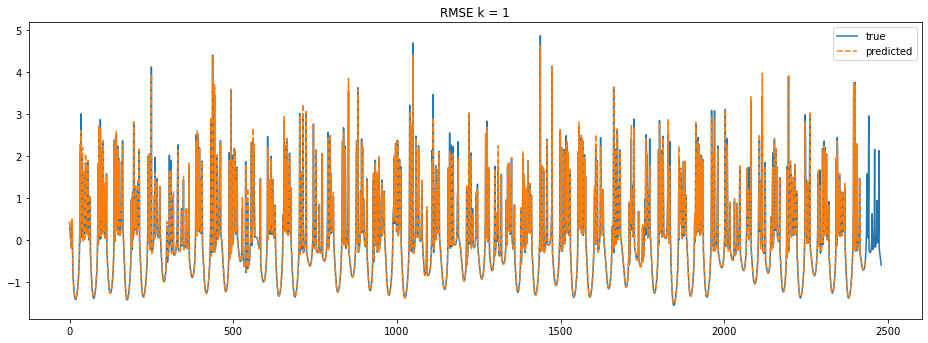

In [68]:
ShowPredict(model, 1, train_dataloader, test_dataloader, test_norm)

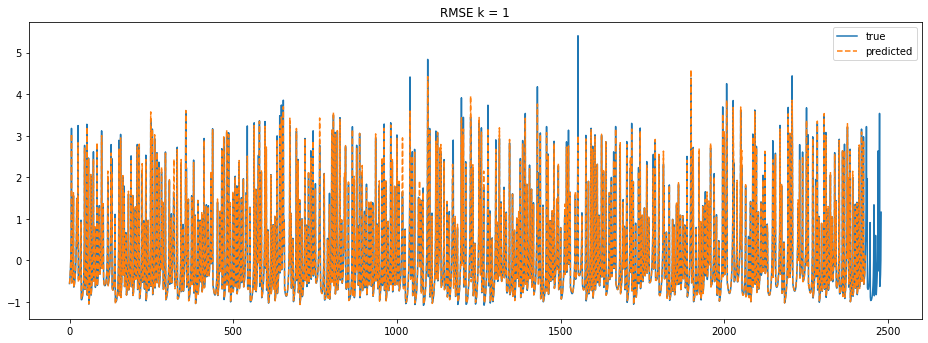

In [69]:
ShowPredict(model2, 1, train_dataloader1, test_dataloader1, test_norm1)

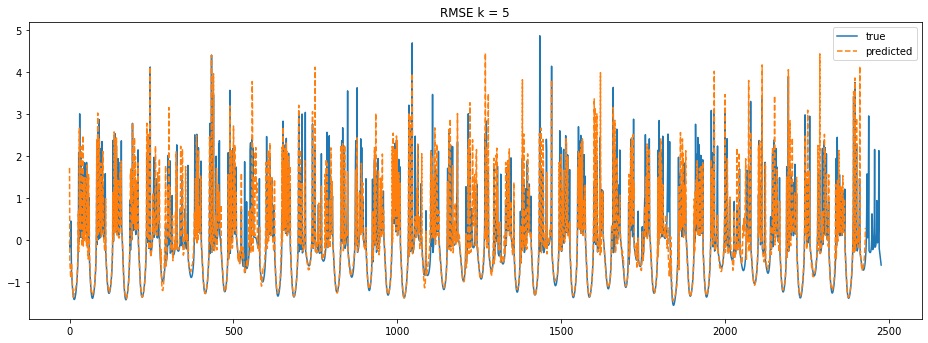

In [70]:
ShowPredict(model, 5, train_dataloader, test_dataloader, test_norm)

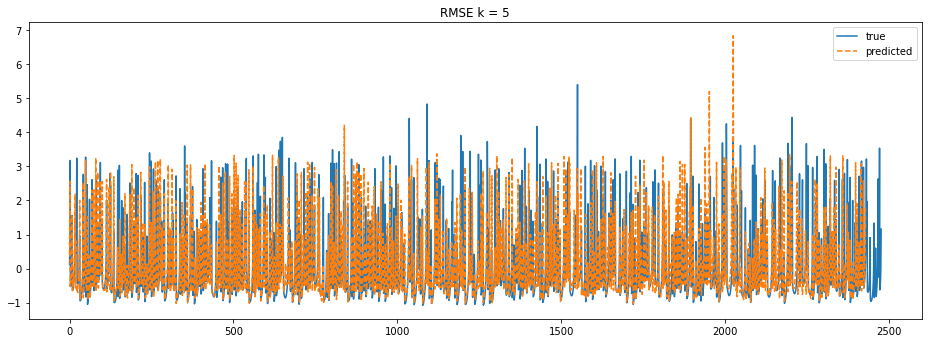

In [71]:
ShowPredict(model2, 5, train_dataloader1, test_dataloader1, test_norm1)

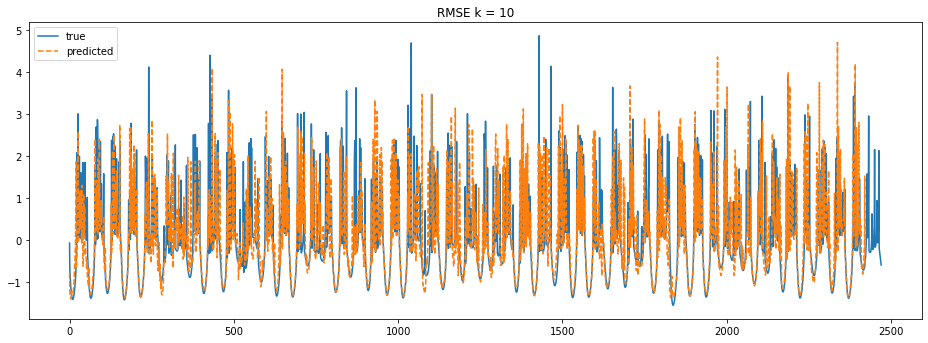

In [72]:
ShowPredict(model, 10, train_dataloader, test_dataloader, test_norm)

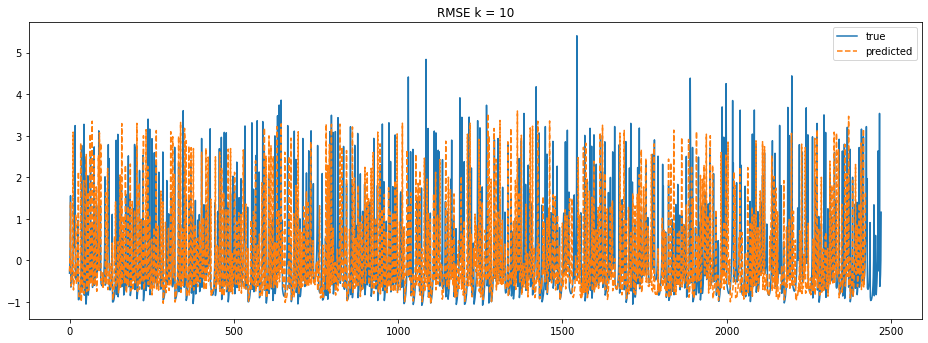

In [73]:
ShowPredict(model2, 10, train_dataloader1, test_dataloader1, test_norm1)

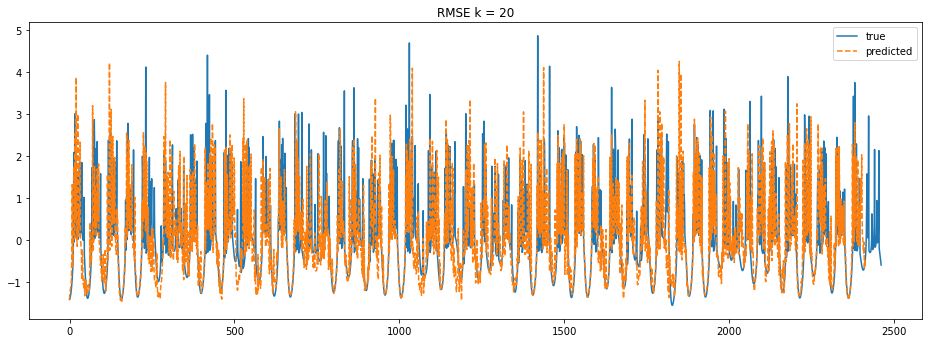

In [74]:
ShowPredict(model, 20, train_dataloader, test_dataloader, test_norm)

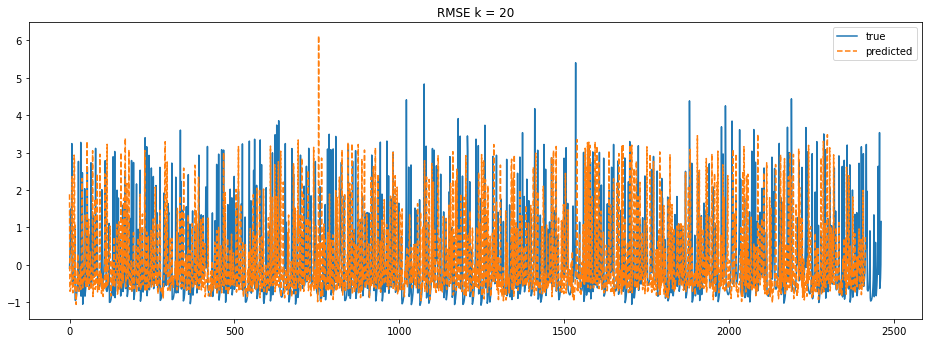

In [75]:
ShowPredict(model2, 20, train_dataloader1, test_dataloader1, test_norm1)